## Behavior-Informed Term Deposit Adoption Predictor: A Machine Learning Approach for Targeted Financial Marketing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
bk = pd.read_csv('bank_m.csv')
bk.head(3)

,age,Gender,job,marital,education,Location,default,balance,housing,loan,...,previous,poutcome,y,age_group,balance_status,log_balance,log_duration,log_pdays,log_campaign,log_previous
0,58,Female,management,married,tertiary,Suburban,no,2143,yes,no,...,0,unknown,no,Adult,Low,7.67043,5.56834,-inf,0.69315,0.0
1,44,Male,technician,single,secondary,Urban,no,29,yes,no,...,0,unknown,no,Adult,Low,3.40120,5.02388,-inf,0.69315,0.0
2,33,Female,entrepreneur,married,secondary,Suburban,no,2,yes,yes,...,0,unknown,no,Adult,Low,1.09861,4.34381,-inf,0.69315,0.0


In [4]:
bk = bk.drop(columns=['Gender', 'Location', 'duration', 'log_duration', 'log_balance', 'log_pdays', 'log_campaign', 'log_previous'])

In [5]:
binary_cols = ['default', 'housing', 'loan', 'y']
for col in binary_cols:
    bk[col] = bk[col].map({'yes': 1, 'no': 0})

education_order = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
bk['education'] = bk['education'].map(education_order)

bk['contact'] = bk['contact'].map({'unknown': 0, 'telephone': 1, 'cellular': 2})

bk['month'] = bk['month'].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5,
    'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10,
    'nov': 11, 'dec': 12
})

bk['poutcome'] = bk['poutcome'].map({
    'unknown': 0, 'other': 1, 'failure': 2, 'success': 3
})

bk = pd.get_dummies(bk, drop_first=True)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#import pickle

In [7]:
x = bk.drop(columns=['y'])
y = bk['y']

x_train_valid, x_test, y_train_valid, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_valid, y_train_valid, test_size=0.25, random_state=42, stratify=y_train_valid
)

In [8]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

smote = SMOTE(random_state=42)
x_train_os, y_train_os = smote.fit_resample(x_train_scaled, y_train)

In [9]:
majority_class = y_train_os.mode()[0]
y_pred_baseline = np.full_like(y_valid, fill_value=majority_class)

y_proba_baseline = np.full_like(y_valid, fill_value=majority_class, dtype=float)

acc_baseline = accuracy_score(y_valid, y_pred_baseline)
try:
    roc_auc_baseline = roc_auc_score(y_valid, y_proba_baseline)
except ValueError:
    roc_auc_baseline = np.nan  

print(f"Baseline Accuracy: {acc_baseline:.4f}")
print(f"Baseline ROC AUC: {roc_auc_baseline}")

Baseline Accuracy: 0.8830
Baseline ROC AUC: 0.5


In [10]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(x_train_os, y_train_os)

y_pred_lr = lr_model.predict(x_valid_scaled)
y_proba_lr = lr_model.predict_proba(x_valid_scaled)[:,1]

print(classification_report(y_valid, y_pred_lr))
print("Validation ROC AUC:", roc_auc_score(y_valid, y_proba_lr))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80      7984
           1       0.22      0.65      0.33      1058

    accuracy                           0.69      9042
   macro avg       0.58      0.68      0.57      9042
weighted avg       0.85      0.69      0.75      9042

Validation ROC AUC: 0.7480799263934296


In [11]:
rf_model = RandomForestClassifier(class_weight = 'balanced', random_state=42, n_estimators=200)
rf_model.fit(x_train_os, y_train_os)

y_pred_rf = rf_model.predict(x_valid_scaled)
y_proba_rf = rf_model.predict_proba(x_valid_scaled)[:,1]

print("Validation Classification Report:\n", classification_report(y_valid, y_pred_rf))
print("Validation ROC AUC:", roc_auc_score(y_valid, y_proba_rf))

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      7984
           1       0.54      0.34      0.42      1058

    accuracy                           0.89      9042
   macro avg       0.73      0.65      0.68      9042
weighted avg       0.87      0.89      0.88      9042

Validation ROC AUC: 0.7862195326380549


In [12]:
xgb_model = XGBClassifier(random_state=42, n_estimators=200)
xgb_model.fit(x_train_os, y_train_os)   

y_pred_xgb = xgb_model.predict(x_valid_scaled)
y_proba_xgb = xgb_model.predict_proba(x_valid_scaled)[:,1]

print("Validation Classification Report:\n", classification_report(y_valid, y_pred_xgb))
print("Validation ROC AUC:", roc_auc_score(y_valid, y_proba_xgb))

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      7984
           1       0.58      0.32      0.41      1058

    accuracy                           0.89      9042
   macro avg       0.75      0.64      0.68      9042
weighted avg       0.88      0.89      0.88      9042

Validation ROC AUC: 0.7833770092169215


In [13]:
metrics = []

models = {
    'Logistic Regression': (lr_model, y_pred_lr, y_proba_lr),
    'Random Forest': (rf_model, y_pred_rf, y_proba_rf),
    'XGBoost': (xgb_model, y_pred_xgb, y_proba_xgb)
}

for name, (model, y_pred, y_proba) in models.items():
    acc = accuracy_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_proba)
    metrics.append({'Model': name, 'Accuracy': acc, 'ROC AUC': roc_auc})

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

best_model_name = metrics_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']
print(f"\nBest model based on ROC AUC: {best_model_name}")

best_model = models[best_model_name][0]
# open('rf_model.pkl', 'wb') as f:
   # pickle.dump(best_model, f)
#with open('scaler.pkl', 'wb') as f:
   # pickle.dump(scaler, f) 


                 Model  Accuracy   ROC AUC
0  Logistic Regression  0.693984  0.748080
1        Random Forest  0.888852  0.786220
2              XGBoost  0.893608  0.783377

Best model based on ROC AUC: Random Forest


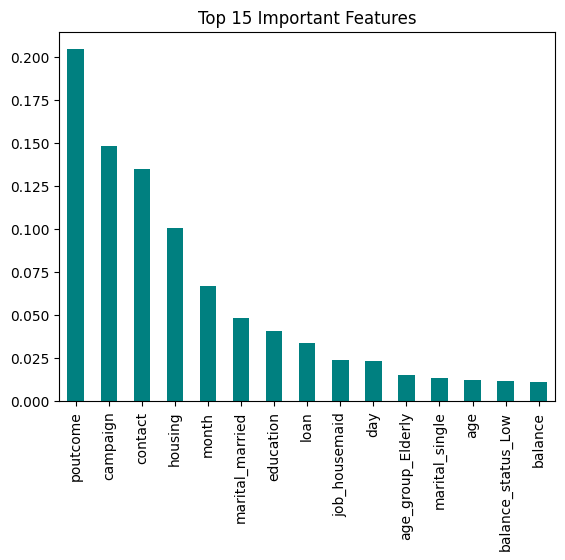

In [14]:
feature_importance = pd.Series(model.feature_importances_, index=x_train.columns)
feature_importance.sort_values(ascending=False).head(15).plot(kind='bar', color='teal')
plt.title("Top 15 Important Features")
plt.show()

Test Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94      7985
           1       0.54      0.32      0.40      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.64      0.67      9043
weighted avg       0.87      0.89      0.88      9043

Test ROC AUC: 0.782092841847841


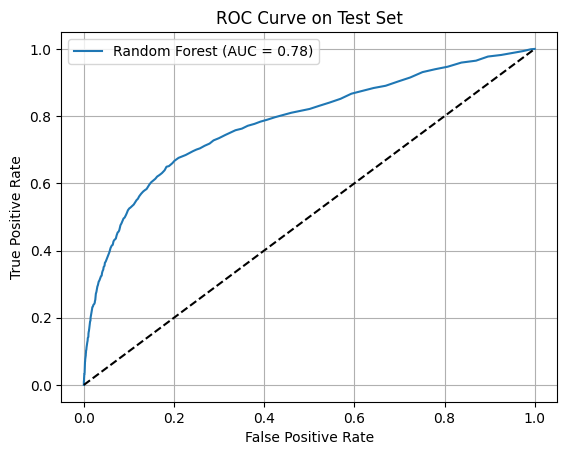

In [15]:
y_test_pred = rf_model.predict(x_test_scaled)
y_test_proba = rf_model.predict_proba(x_test_scaled)[:,1]

print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_test_proba):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Set')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
results = x_test.copy()
results['Actual'] = y_test.values
results['Predicted'] = y_test_pred
results['Probability'] = y_test_proba

results.to_csv("model_predictions.csv", index=False)

## Final Conclusion
In this project, we built a machine learning pipeline to predict customer adoption of investment products (term deposits) using demographic, financial, and interactional data, guided by the Theory of Planned Behavior.

Our workflow included:
Rigorous data preprocessing (encoding, scaling, handling class imbalance using SMOTE).
Structured feature engineering to transform raw data into meaningful inputs.
Training and evaluating multiple models: Logistic Regression, Random Forest, and XGBoost.

Among the models, the Random Forest classifier achieved the best ROC-AUC score, highlighting its ability to capture non-linear relationships and feature interactions. Feature importance analysis identified previous campaign outcome, customer balance, and contact duration as top predictors — aligning with behavioral cues like perceived value and intent.

## Business Implications
Insights from the model can be used to prioritize high-probability leads for investment outreach.
Marketing teams can personalize campaigns based on influential features such as job type, education, and contact history.
Predictive modeling facilitates data-driven decision-making, reducing marketing costs and improving conversion rates.

## Future Work
Refine model performance with ensemble stacking or advanced boosting techniques.
Incorporate additional behavioral signals (e.g., website interaction, social media sentiment).
Deploy the model with real-time dashboards for live scoring and actionable alerts.
Conduct A/B tests to validate uplift in marketing conversion rates.